In [56]:
import sys
import os
import importlib

parent = os.path.dirname(os.getcwd())
sys.path.insert(0, parent)

import h5py
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize


from Helpers import loadData, multiplot, sphereMask, dataSizes, chunkor
importlib.reload(sys.modules['Helpers.chunkor'])
importlib.reload(sys.modules['Helpers.dataSizes'])
importlib.reload(sys.modules['Helpers'])

<module 'Helpers' from 'c:\\Users\\Lab User\\Desktop\\temp1\\Granular-Compression\\Identification\\Helpers\\__init__.py'>

In [46]:
folderData = os.path.join(os.path.dirname(parent),'Data')
data = loadData(location=folderData, fileName='downscale_17.hdf5')
a,b,c = data.shape
data = data[:a-1,:b-1,:c-1]
print(data.shape)

(411, 511, 545)


In [3]:
with h5py.File(rf'{folderData}/Scan_17.hdf5','r') as f: 
    legData = f['RawData/Scan_17'][:] # (slices, rows, width)

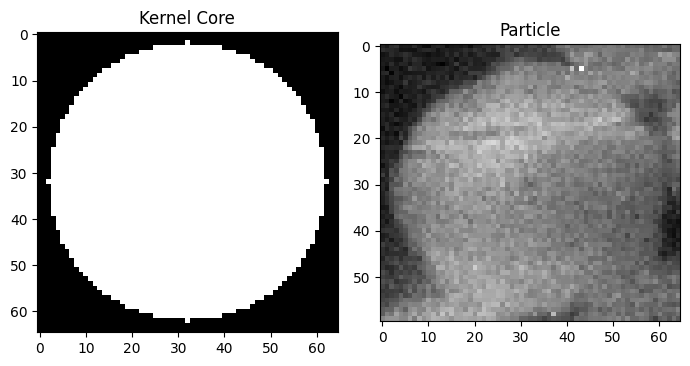

In [47]:
kernel = sphereMask(diameter=100,pad=2,scale=.6)
particle = data[90:150,35:100,25]

_,__,c= kernel.shape
core = kernel[:,:,int(c/2)]

multiplot(core,particle,ax_vis=True,titles=['Kernel Core','Particle'])

In [5]:
from skimage.feature import canny, peak_local_max
from scipy.signal import fftconvolve
import pandas as pd
import torch
import torch.fft as fft

In [48]:
if torch.cuda.is_available():
    print(f"Available: {torch.cuda.get_device_name(0)}")

Available: NVIDIA RTX A2000 12GB


In [57]:
print(data.shape)
print(kernel.shape)

(411, 511, 545)
(65, 65, 65)


In [58]:
pchunks, pkern = chunkor(data,kernel)

Desktop device detected: NVIDIA RTX A2000 12GB
Data Ram: 0.21 GB
Attempting 4 partitions


,VRam
Total,11.99
Reserved,1.31
Allocated,0.26


In [69]:
dsz = np.array(pchunks[0].numpy().shape)
ksz = np.array(pkern.numpy().shape)
print(dsz)
print(ksz)
pads = (dsz-ksz)/2
print(pads)

[475 351 368]
[129 129 129]
[173.  111.  119.5]


In [34]:
for c in pchunks:
    print(c.shape)

torch.Size([476, 352, 369])
torch.Size([476, 352, 369])
torch.Size([476, 352, 369])
torch.Size([476, 352, 369])


In [35]:
blank = torch.zeros(pchunks[0].shape)

In [36]:
print(blank.shape)

torch.Size([476, 352, 369])


In [29]:
gKern = pkern.cuda()
fgKern = fft.rfftn(gKern)

In [30]:
print(gKern.shape)
print(fgKern.shape)

torch.Size([129, 129, 129])
torch.Size([129, 129, 65])


In [33]:
print(fgKern[:3,:3,:3])

tensor([[[ 28835655.0000+0.0000j, -23123367.0900-563244.6906j,
           10623119.1617+517828.3643j],
         [-23123367.0900-563244.6906j,  18238077.1508+889022.6604j,
           -7706751.6040-564061.5145j],
         [ 10623119.1617+517828.3643j,  -7706751.6040-564061.5145j,
            1741764.5604+170210.5165j]],

        [[-23123367.0900-563244.6906j,  18238077.1508+889022.6604j,
           -7706751.6040-564061.5145j],
         [ 18238077.1508+889022.6604j, -14090304.2189-1031277.3455j,
            5296017.6699+517542.9122j],
         [ -7706751.6040-564061.5145j,   5296017.6699+517542.9122j,
            -488236.8149-59746.7946j]],

        [[ 10623119.1617+517828.3643j,  -7706751.6040-564061.5145j,
            1741764.5604+170210.5165j],
         [ -7706751.6040-564061.5145j,   5296017.6699+517542.9122j,
            -488236.8149-59746.7946j],
         [  1741764.5604+170210.5165j,   -488236.8149-59746.7946j,
           -1741682.4891-256322.5392j]]], device='cuda:0',
       dtype

In [27]:
gKern = pkern.cuda()
fgKern = fft.rfftn(gKern)
del gKern

convMaps = []
for chunk in pchunks:

    gChunk = chunk.cuda()
    fgChunk = fft.rfftn(gChunk)
    del gChunk

    fgChunk *= fgKern
    gChunk = fft.ifftn(fgChunk)
    del fgChunk

    chunk = gChunk.cpu()
    del gChunk

    convMaps.append(chunk)

RuntimeError: The size of tensor a (185) must match the size of tensor b (65) at non-singleton dimension 2

In [ ]:
    nuData = torch.from_numpy(data)
    nuKern = torch.from_numpy(kernel)
    
    gpuData = nuData.to('cuda')
    gpuKern = nuKern.to('cuda')

In [ ]:
# FFT assumes cyclical boundary conditions, gotta pad the chunks and kernel or something
gpuKern =  torch.from_numpy(kernel).cuda()
frenchKern  = fft.rfft(gpuKern)

convChunks = []
for chunk in chunks:
    gpuChunk = torch.from_numpy(chunk).cuda() 
    frenchChunk = fft.rfft(gpuChunk)
    del gpuChunk

    frenchChunk *= frenchKern
    convolvedChunk = frenchChunk.cpu().numpy()
    convChunks.append(convolvedChunk)
    del frenchChunk

RuntimeError: The size of tensor a (153) must match the size of tensor b (33) at non-singleton dimension 2

In [ ]:
# !!! CLAUDES INTERPRETATION ON HOW TO SOLVE THIS, need to pad kernel and data, and inverse the fft!!!

import torch.fft as fft
import torch.nn.functional as F

# Prepare kernel
gpuKern = torch.from_numpy(kernel).float().cuda()

convChunks = []
for chunk in chunks:
    gpuChunk = torch.from_numpy(chunk).float().cuda()
    
    # Zero-pad both to size (chunk_size + kernel_size - 1)
    pad_size = tuple((k//2, k//2) for k in kernel.shape[::-1])  # Padding for each dim
    gpuChunk_padded = F.pad(gpuChunk, [p for pair in pad_size for p in pair])
    
    # 3D FFT
    frenchChunk = fft.rfftn(gpuChunk_padded)
    del gpuChunk, gpuChunk_padded
    
    # Kernel FFT (must match padded chunk size!)
    frenchKern = fft.rfftn(gpuKern, s=frenchChunk.shape)
    
    # Multiply in frequency domain
    frenchChunk *= frenchKern
    del frenchKern
    
    # INVERSE FFT to get back to spatial domain
    convolvedChunk = fft.irfftn(frenchChunk)
    del frenchChunk
    
    # Crop padding to get valid region
    # ... cropping logic here ...
    
    convChunks.append(convolvedChunk.cpu().numpy())

In [8]:
a,b,c = legData.shape
cat = legData[0:int(a/2),0:int(b/1.5),0:int(c/2)]
dataSizes(globals().items())

,Mb,Gb
legData,20884,20.4
cat,3481,3.4
data,220,0.2
kernel,2,0.0
core,0,0.0
particle,0,0.0


In [9]:
if torch.cuda.is_available():
    print(f"Available: {torch.cuda.get_device_name(0)}")
    nuLega = torch.from_numpy(legData)
    nuData = torch.from_numpy(data)
    nuKern = torch.from_numpy(kernel)

    gpuLega = nuLega.to('cuda')
    gpuData = nuData.to('cuda')
    gpuKern = nuKern.to('cuda')
    print(f"Data Loc:  {gpuData.device}")
else:
    print("No GPU available")

Available: NVIDIA RTX A2000 12GB
Data Loc:  cuda:0


In [10]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  21106 MiB |  21326 MiB |  21328 MiB | 227426 KiB |
|       from large pool |  21106 MiB |  21326 MiB |  21328 MiB | 227426 KiB |
|       from small pool |      0 MiB |      0 MiB |      0 MiB |      0 KiB |
|---------------------------------------------------------------------------|
| Active memory         |  21106 MiB |  21326 MiB |  21328 MiB | 227426 KiB |
|       from large pool |  21106 MiB |  21326 MiB |  21328 MiB |

In [11]:
print(legData.shape,type(legData[10,2,1]))
print(np.round(legData.nbytes/(1024**3),2),'Gb')


(2184, 2448, 2048) <class 'numpy.uint16'>
20.4 Gb


In [12]:
# Start recording memory snapshot history
torch.cuda.memory._record_memory_history(max_entries=100000)

fKern = fft.rfft(gpuKern, norm='forward')
fData = fft.rfft(gpuData, norm='forward')

# Dump memory snapshot history to a file and stop recording
torch.cuda.memory._dump_snapshot("profile.pkl")
torch.cuda.memory._record_memory_history(enabled=None)

In [13]:
fKern = fft.rfft(gpuKern, norm='forward')
fData = fft.rfft(gpuData, norm='forward')
fLega = fft.rfft(gpuLega, norm='forward')

OutOfMemoryError: CUDA out of memory. Tried to allocate 40.83 GiB. GPU 0 has a total capacity of 11.99 GiB of which 0 bytes is free. Of the allocated memory 61.84 GiB is allocated by PyTorch, and 18.31 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63])
torch.Size([64, 33])
torch.Size([64, 33])


ValueError: x and y must be the same size

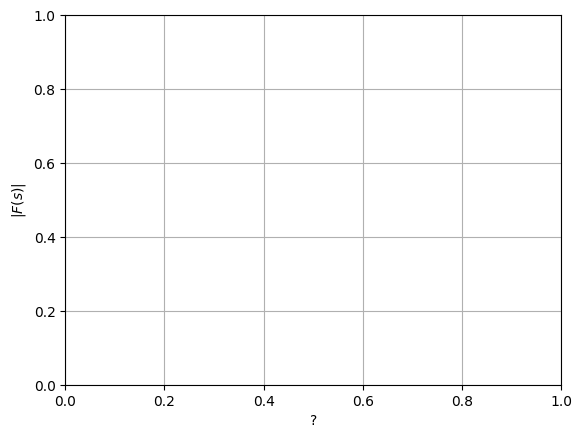

In [ ]:
fourier = fourier.cpu()
absolutes = torch.abs(fourier)

print(torch.arange(absolutes.shape[0]))
print(fourier.shape)
print(absolutes.shape)

fig, ax = plt.subplots()
ax.set_xlabel('?')
ax.set_ylabel('$|F(s)|$')
ax.grid()
ax.scatter(x=torch.arange(absolutes.shape[0]), y=absolutes, s=8)

In [ ]:
print(fourier.shape,lay.shape)

torch.Size([64, 33]) torch.Size([64, 64])


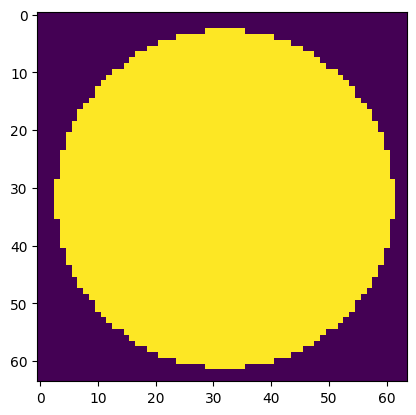

In [ ]:
x = torch.rand(5, 3)
print(x)

tensor([[0.4298, 0.5493, 0.5596],
        [0.1986, 0.6548, 0.3524],
        [0.3335, 0.9568, 0.6567],
        [0.3206, 0.5727, 0.2256],
        [0.2307, 0.3356, 0.6051]])


In [ ]:
torData = torch.from_numpy(data)
print(torData.device)

cpu


In [ ]:
dog = torData.to('cuda')
print(torData.device)
print(dog.device)

cpu
cuda:0


In [ ]:
tensor = np.array([1,2])
if torch.accelerator.is_available():
    tensor = tensor.to(torch.accelerator.current_accelerator())

AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [ ]:
raise MemoryError
chiMap = fftconvolve(cat,kernel,mode='same')
invChi = 1/(chiMap+1e-12)

KeyboardInterrupt: 

In [ ]:
chiMap = fftconvolve(data,kernel,mode='full')
invChi = 1/(chiMap+1e-12)

In [ ]:
coords = peak_local_max(data, min_distance=int(MinSep), threshold_abs=CutOff)

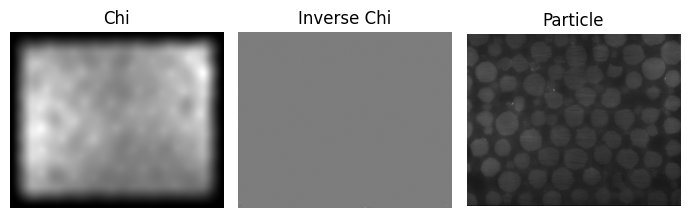

In [ ]:
multiplot(chiMap[:,:,50],50*invChi[:,:,50],data[:,:,50],titles=['Chi','Inverse Chi', 'Particle'])

In [ ]:
chi3D, _ = chiimg3D_FFT(dataRescale, ipi)
Np, px, py, pz = findpeaks3D(1./(chi3D+1e-12), Cutoff=Cutoff, MinSep=MinSep)

In [ ]:
def convolution3D_FFTdomain(img, kernel): 
    return fftconvolve(img, kernel, mode='same')

def chiimg3D_FFT(img, ip, W=None, Wip2=None):
    if W is None: 
        W = ip
    if Wip2 is None: 
        Wip2 = convolution3D_FFTdomain(np.ones_like(img), ip**2 * W)
    return 1 + (-2*convolution3D_FFTdomain(img, ip*W) + convolution3D_FFTdomain(img**2, W))/Wip2, Wip2



def findpeaks3D(img, CutOff=0, MinSep=1):
    coords = peak_local_max(img, min_distance=int(MinSep), threshold_abs=CutOff)
    spx, spy, spz = coords[:, 2], coords[:, 1], coords[:, 0]  # XYZ
    return len(spx), spx, spy, spz
